In [1]:
import pickle
import numpy as np
import itertools
import time
import os
import segutil
from contextlib import nullcontext
import torch
from bertviz import model_view
import model

In [2]:
import importlib
importlib.reload(model)

<module 'model' from '/Users/rastislavhronsky/ML-research/nanoGPT/model.py'>

In [3]:
# -----------------------------------------------------------------------------
out_dir = 'out-shakespeare-char'
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
max_new_tokens = 100 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'mps' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------

In [4]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# init from a model saved in a specific directory
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = model.GPTConfig(**checkpoint['model_args'])
gpt = model.GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)


number of parameters: 1.21M


<All keys matched successfully>

In [5]:
gpt.eval()
gpt.to(device)
if compile:
    gpt = torch.compile(gpt) # requires PyTorch 2.0 (optional)

if gpt.config.vocab_size == 256:
    # byte vocab
    encode = lambda s: [ord(c) for c in s]
    decode = lambda l: ''.join([chr(i) for i in l])
else: 
    # gpt2 vocab 
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

tokens, atts = [], []
num_samples = 30 
# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y, att = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            tokens.append(decode(y[0].tolist()))
            atts.append(att[-1]) # only save the last (full sequence) attention matrix
            print(tokens[-1])
            print('---------------')



That let the world be too much, and affecting,
That art thou discover'd to men and know.

Second Gen
---------------

RICHARD II:
Never well did for mine.

LUCENTIO:
O, what say, I know?

POLIXENES:
You saYad with him.
---------------

POMPEY:
For the prince, thou hast thou must didsper come to
make a end-house to have his doom.

POLI
---------------

I have offer'd word and his view or common ears.
3 KING HENRY VI

KING HENRY VI:
I will not hear tha
---------------


ABHORSON:
To come your mother malice,
Let him be this tale fearful as we much
As as as ended of my 
---------------

To manners, come. But thou didst not forth.
Dog thou conscied think the bade for thy womb,
This inte
---------------

And yet to my wife your wrong to this prace.

GLOUCESTER:

KING EDWARD IV:
Nay, I am grain for my lo
---------------


PAULINA:
So, no more.

LEONTES:
I leave you to part me; your fit happily
Will I be procude the hous
---------------

And thus I part his forth again of thee,
For man the bl

In [6]:
att = atts[0]
tok = tokens[0]
print(''.join(tok))
model_view([el.unsqueeze(0) for el in att][:2], 
           tokens=tok[1:],
           display_mode='light')


That let the world be too much, and affecting,
That art thou discover'd to men and know.

Second Gen


<IPython.core.display.Javascript object>

#### Predicting attention

Now we will try to predict the attention as function of spatial info. 

In [108]:
from scipy.sparse import coo_array
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt 
import matplotlib as mpl

def mse(pred, true): 
    return np.mean((pred-true)**2)

In [8]:
def fmt(token): 
    token = token.replace("\n", "\\n")
    token = token.replace(" ", "_")
    return token

In [10]:
def get_boundary_distance(boundary_token, tokens):
    intervals = np.argwhere(tokens==boundary_token).astype(int).flatten()
    if intervals[-1] != len(tokens): 
        intervals = np.hstack([intervals, [len(tokens)]])
    if intervals[0] != 0: 
        intervals = np.hstack([[0], intervals])
    intervals = np.hstack([intervals[:-1].reshape(-1,1), intervals[1:].reshape(-1,1)])
    last_boundary_pos = np.hstack([np.repeat(l, u-l) for l,u in intervals])
    last_segment_size = np.hstack([np.repeat(u-l, u-l) for l,u in intervals])
    #last_segment_size[last_segment_size==1] = 2 # cant have ones, because we will divide with this-1 later
    last_boundary_dist = np.arange(len(tokens)) - last_boundary_pos
    last_boundary_dist = last_boundary_dist / (last_segment_size)
    return last_boundary_dist

get_boundary_distance(' ', np.array(list('dubry vecer ako sa  mate')))

array([0.        , 0.2       , 0.4       , 0.6       , 0.8       ,
       0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 0.        , 0.25      , 0.5       , 0.75      ,
       0.        , 0.33333333, 0.66666667, 0.        , 0.        ,
       0.2       , 0.4       , 0.6       , 0.8       ])

In [52]:
# we need to be able to predict att_score as a function of: 
# f(i, j, i-j)
# f(bl_i, bl_j, nl_i, nl_j)
# use uniform weights as baseline? 

# first make training data 

layer = 1
head = 5

def make_data(layer, head): 
    x_pos, x_seg, y = [], [], []
    for att, tok in zip(atts, tokens): 
        tok = np.array(list(tok[:-1]))
        dist_blank = get_boundary_distance(boundary_token=' ', tokens=tok)
        dist_newline = get_boundary_distance(boundary_token='\n', tokens=tok)

        at_arr = att[layer][head].numpy()
        at = coo_array(at_arr)
        for i,j in zip(*at.coords): 
            x_pos.append([i, j, i-j])
            x_seg.append([dist_blank[i], dist_blank[j], dist_newline[i], dist_newline[j]])
            y.append(at_arr[i,j])
    return x_pos, x_seg, y

x_pos, x_seg, y = make_data(layer=layer, head=head)

In [12]:
x = np.hstack([x_pos, x_seg])
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
print(f"{len(y_train)} train examples, {len(y_test)} test examples")

121200 train examples, 30300 test examples


epoch 0, train error 0.89, test error 0.89*BL
epoch 1, train error 0.81, test error 0.82*BL
epoch 2, train error 0.76, test error 0.77*BL
epoch 3, train error 0.72, test error 0.73*BL
epoch 4, train error 0.67, test error 0.68*BL
epoch 5, train error 0.64, test error 0.66*BL
epoch 6, train error 0.62, test error 0.64*BL
epoch 7, train error 0.61, test error 0.62*BL
epoch 8, train error 0.59, test error 0.61*BL
epoch 9, train error 0.58, test error 0.60*BL
epoch 10, train error 0.58, test error 0.59*BL
epoch 11, train error 0.57, test error 0.59*BL
epoch 12, train error 0.56, test error 0.58*BL
epoch 13, train error 0.56, test error 0.59*BL
epoch 14, train error 0.59, test error 0.60*BL
epoch 15, train error 0.56, test error 0.58*BL
epoch 16, train error 0.55, test error 0.57*BL
epoch 17, train error 0.55, test error 0.57*BL
epoch 18, train error 0.56, test error 0.58*BL
epoch 19, train error 0.55, test error 0.57*BL


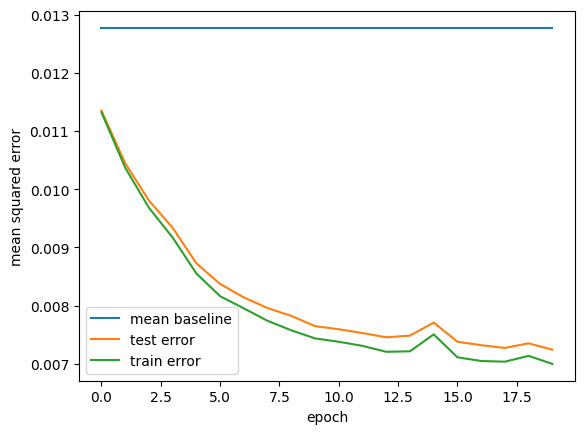

In [39]:
hidden_size = 128
num_layers = 3
model_args = dict(hidden_layer_sizes=[hidden_size]*num_layers, 
                   learning_rate_init=3e-4, 
                   solver='adam', 
                   batch_size=1000,)
mlp = MLPRegressor(**model_args, )

BL = mse(np.mean(y_train), y_test)

#feat = slice(0, 3)
feat = slice(3, None)

errs_test, errs_train = [], []
for i in range(20):
    mlp.partial_fit(x_train[:, feat], y_train)
    errs_test.append(mse(mlp.predict(x_test[:, feat]), y_test))
    errs_train.append(mse(mlp.predict(x_train[:, feat]), y_train))
    print(f"epoch {i}, train error {errs_train[-1]/BL:.2f}*BL, test error {errs_test[-1]/BL:.2f}*BL")

plt.plot(np.arange(len(errs_test)), [BL]*len(errs_test), label='mean baseline')
plt.plot(np.arange(len(errs_test)), errs_test, label='test error')
plt.plot(np.arange(len(errs_test)), errs_train, label='train error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.legend()

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [40]:
reg = DecisionTreeRegressor(max_depth=10)
feat = slice(3, None)
reg.fit(x_train[:, feat], y_train)
err_test = mse(reg.predict(x_test[:, feat]), y_test)
err_train = mse(reg.predict(x_train[:, feat]), y_train)
print(f"rel train error {err_train/BL:.2f}*BL, rel test error {err_test/BL:.2f}*BL")

rel train error 0.41*BL, rel test error 0.53*BL


In [48]:
reg = DecisionTreeRegressor(max_depth=10)
feat = slice(0, None)
reg.fit(x_train[:, feat], y_train)
err_test = mse(reg.predict(x_test[:, feat]), y_test)
err_train = mse(reg.predict(x_train[:, feat]), y_train)
print(f"rel train error {err_train/BL:.2f}*BL, rel test error {err_test/BL:.2f}*BL")

rel train error 0.08*BL, rel test error 0.11*BL


It seems that decision tree of depth around 10 works the best for predicting attention scores. 

Now we can run the simulation for all layers and attention heads and store the results in a csv file. 

In [62]:
import pandas as pd

In [50]:
layers = list(range(gpt.config.n_layer))
heads = list(range(gpt.config.n_head))

In [54]:
featsets = [
    ('pos', slice(0,3)),
    ('seg', slice(3,None)),
    ('pos+seg', slice(0,None)),
]

In [99]:
regressor = DecisionTreeRegressor
regressor_kwargs = dict(max_depth=10)
test_size=.2
results = []

for head, layer in itertools.product(heads, layers): 
    x_pos, x_seg, y = make_data(layer=layer, head=head)
    x = np.hstack([x_pos, x_seg])
    y = np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    BL = mse(np.mean(y_train), y_test)

    for feat_label, feat in featsets:
        reg = regressor(**regressor_kwargs)
        reg.fit(x_train[:, feat], y_train)
        err_test = mse(reg.predict(x_test[:, feat]), y_test)
        err_train = mse(reg.predict(x_train[:, feat]), y_train)
        run_attribs=dict(head=head, layer=layer, feat=feat_label)
        print(f"rel test error {err_test/BL:.2f}*BL", str(run_attribs))
        err = dict(err_test=err_test, err_train=err_train, err_bl=BL)
        regressor_attribs = {'class': str(regressor), **regressor_kwargs}
        regressor_attribs = {f"regressor_{key}": val for key, val in regressor_attribs.items()}
    
        results.append({**run_attribs, **err, **regressor_attribs})

rel test error 0.15*BL {'head': 0, 'layer': 0, 'feat': 'pos'}
rel test error 0.65*BL {'head': 0, 'layer': 0, 'feat': 'seg'}
rel test error 0.09*BL {'head': 0, 'layer': 0, 'feat': 'pos+seg'}
rel test error 0.38*BL {'head': 0, 'layer': 1, 'feat': 'pos'}
rel test error 0.69*BL {'head': 0, 'layer': 1, 'feat': 'seg'}
rel test error 0.28*BL {'head': 0, 'layer': 1, 'feat': 'pos+seg'}
rel test error 0.54*BL {'head': 0, 'layer': 2, 'feat': 'pos'}
rel test error 0.85*BL {'head': 0, 'layer': 2, 'feat': 'seg'}
rel test error 0.41*BL {'head': 0, 'layer': 2, 'feat': 'pos+seg'}
rel test error 0.68*BL {'head': 0, 'layer': 3, 'feat': 'pos'}
rel test error 0.88*BL {'head': 0, 'layer': 3, 'feat': 'seg'}
rel test error 0.61*BL {'head': 0, 'layer': 3, 'feat': 'pos+seg'}
rel test error 0.69*BL {'head': 0, 'layer': 4, 'feat': 'pos'}
rel test error 0.84*BL {'head': 0, 'layer': 4, 'feat': 'seg'}
rel test error 0.63*BL {'head': 0, 'layer': 4, 'feat': 'pos+seg'}
rel test error 0.78*BL {'head': 0, 'layer': 5, 'fe

In [104]:
df = pd.DataFrame(results)
df['r2'] = 1-df['err_test']/df['err_bl']
df.to_csv('att_regression.tsv', sep='\t')

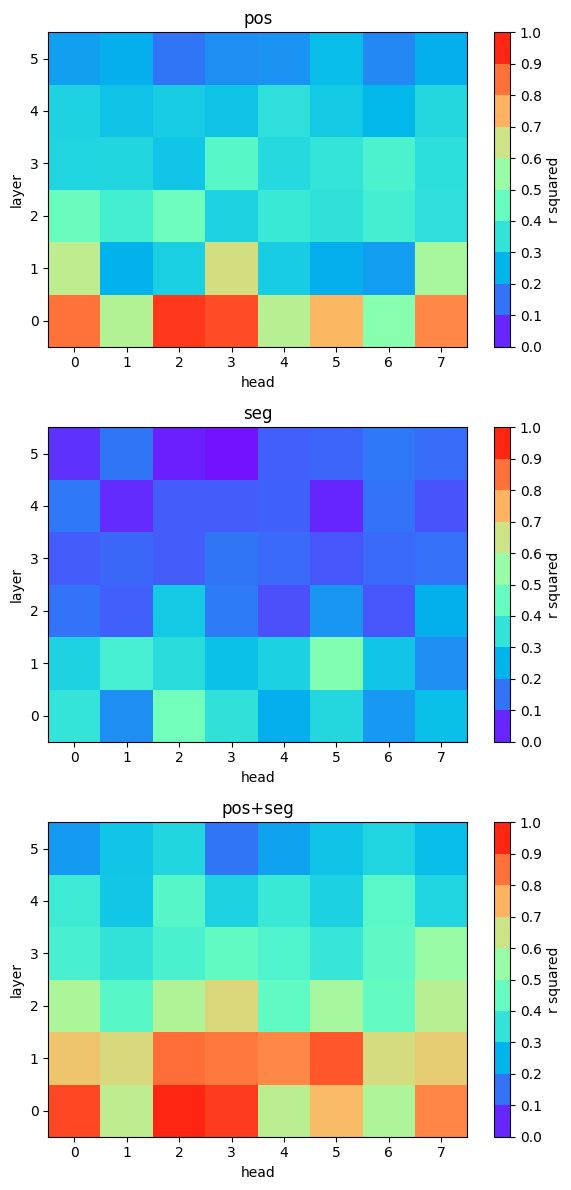

In [124]:
cmap = plt.cm.rainbow  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 1, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,12))

for (feat, _), ax in zip(featsets, axes): 
    hm = np.zeros((gpt.config.n_layer, gpt.config.n_head))
    for i, row in df[df.feat==feat].iterrows(): 
        hm[row['layer'], row['head']]=row['r2']
    c = ax.imshow(hm, vmin=0, vmax=1, cmap=cmap, origin='lower' )
    ax.set_title(feat)
    ax.set_ylabel('layer')
    ax.set_xlabel('head')
    cbar = fig.colorbar(c, ax=ax, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='{x:.1f}')
    cbar.set_label('r squared')
fig.tight_layout()